# Multilabel Classification Problem

In [ ]:
import os
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from aisee import DatasetFromDataFrame, Trainer, VisionClassifier
from PIL import Image

## Get the data

In this section of code, we are **downloading and extracting a dataset of poster images** from a .zip file hosted on **Hugging Face**. 

First, the current working directory of the notebook is obtained and stored in the variable `notebook_dir`. 

Next, the URL of the .zip file is defined and stored in the `url` variable. 

The dataset is then downloaded using the `requests` library, and the content of the response is written to a file named `data.zip` in the current working directory. 

Finally, the `zipfile` library is utilized to extract the contents of the downloaded .zip file into the current working directory, after which the .zip file is closed.

In [2]:
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Define the URL to download the dataset
url = 'https://huggingface.co/IIC/aisee_resources/resolve/main/poster.zip'

response = requests.get(url)

# Download the dataset from the URL and save it as "data.zip" in the current working directory
with open('data.zip', 'wb') as file:
    file.write(response.content)

# Extract the contents of the downloaded zip file into the current working directory
archivo_zip = zipfile.ZipFile(os.path.join(notebook_dir, 'data.zip'))
archivo_zip.extractall(os.path.join(notebook_dir))
archivo_zip.close()

Now we have a folder called **multi label daset** with a subfolder with all the images and a .csv file with the label information.




In [3]:
#Load dataset
data = pd.read_csv('./multi_label_dataset/train.csv')
data.head()


,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Trasform to AISee dataframe format:

                     path           |   car   |   motorbike   |   bus
            -------------------------------------------------------------
            "sample/vehicles1.png"  |    1    |       1       |    0
            "sample/vehicles2.png"  |    0    |       0       |    1
            "sample/vehicles3.png"  |    1    |       0       |    1
            "sample/vehicles4.png"  |    1    |       0       |    0


In [4]:
#Create path column
data['path'] = ['multi_label_dataset/Images/'+str(id)+'.jpg' for id in data.Id]

#Drop useless columns
data.drop(columns =['Id', 'Genre'], inplace = True)

#Create fold colum
train_frac, val_frac, test_frac = 0.7, 0.1, 0.2
train_count = int(len(data) * train_frac)
val_count = int(len(data) * val_frac)
labels = ['train'] * train_count + ['val'] * val_count + ['test'] * (len(data) - train_count - val_count)

#Random the images fold
np.random.seed(42)
np.random.shuffle(labels)
data['fold'] = labels


data.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,path,fold
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,multi_label_dataset/Images/tt0086425.jpg,train
1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,multi_label_dataset/Images/tt0085549.jpg,train
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,multi_label_dataset/Images/tt0086465.jpg,train
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,multi_label_dataset/Images/tt0086567.jpg,test
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,multi_label_dataset/Images/tt0086034.jpg,test


The task that will be performed with this data is to train a model to classify multiple label images of posters.
Let's see some images:

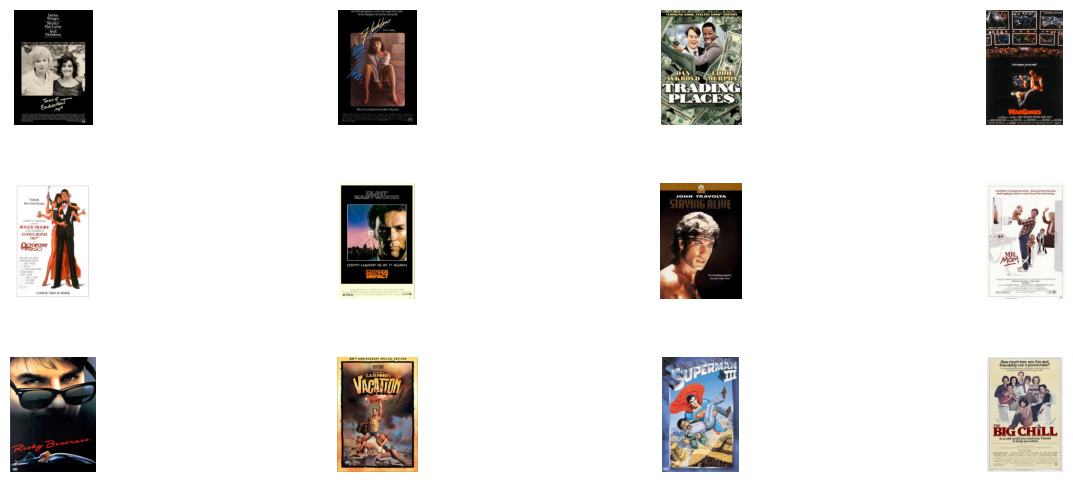

In [5]:
#Create the dataset
train_df = DatasetFromDataFrame(data)

#Plot images 
f,ax = plt.subplots(3,4, figsize=(15, 6))
f.subplots_adjust(wspace=0.7, hspace=0.5)
for i, (img, label, path) in enumerate(train_df):
    if i >= 12:
        break
    ax[i//4,i%4].imshow(Image.open(path))
    ax[i//4,i%4].axis('off') 
plt.show()

## VisionClassifier Instance 

These are all parameters with their respective explanations:

- **model_name**: (`str`) Name of the model that will be obtained from the timm library.

- **num_classes**: (`int`) Number of classes in the problem. The number of classes will be the number of outputs of the neural net.

- **class_to_idx**: (dict[`str`, `int`], default=None) Equivalence between the label and the index of the neural net output. This parameter is equivalent to label2id of the transformers library.

- **weights_path**: (`str`, default=None) Directory where network weights are located. If value is different from None, pretrained weigths from the timm library will be ignored.

- **learning_method**: (`str`, default="freezed") Possible values: from_scratch, freezed, and unfreezed:
    - **from_scratch**: The model will be trained from scratch, without using any pre-trained weights contained in the timm library.
    - **freezed**: The model will be trained using pre-trained weights from the timm library. For this training, all layers of the network will be frozen (weights will not be updated) except for the last - layer, and the extra layer if it is added with the extra_layer parameter.
    - **unfreezed**: The model will be trained using pre-trained weights from the timm library. In this case, all layers of the network will be updated without exception.

    Note that if custom weights are passed in the custom_weights parameter, the network weights will be those, and the pre-trained weights from the timm library will be ignored.

- **extra_layer**: (`int`, default=None) If value is different from None, a linear layer is added before the last layer with extra_layer number of neurons. If None, this does nothing.

- **dropout**: (`float`, default=None) If dropout has a value different from None, dropout layer is added before the last layer. Otherwise, this does nothing.

- **task**: (`str`, default="single_label") Task to be resolved. Possible values: "single_label", "multi_label".

- **device**: (`str`, default="cpu") Device where the neural network will be running. Example: "cuda:1", "cpu".

In [6]:
model_name = 'densenet121'
num_classes = 25


classifier = VisionClassifier(model_name, num_classes, task='multi_label', device='cuda:0')


## Trainer Instance 

These are all parameters with their respective explanations:

* **base_model** (`VisionClassifier`): An instance of VisionClassifier.

* **data** (`Union[pd.DataFrame, str]`): A DataFrame or a string which contains the training data:
    * If it is a dataframe:
        * If it is a multiclass problem: the dataframe must contain a `path` column with the full path of the image, a `label` column with the label assigned to the image and a `fold` column that indicates the 'train' and 'val' samples.
        * If it is a multilabel problem: the dataframe must contain a "path" column with the full path of the image, one column for each class in the problem and a `fold` column . The classes that belong to that image will be indicated with a "1" and those that do not with a "0".
    * If it is a string, it must be a directory which should contain subfolders with training ('train') and validation ('val') samples and second subfolders with labels.

* **output_dir** (`str`, default=None): File where the weights of the neural network will be saved. If None output_dir = 'weights_model_name_time.pt'

* **lr** (`float`, default=0.001): Learning rate used by the torch optimizer.

* **batch_size** (`int`, default=16): Number of training samples.

* **num_epochs** (`int`, default=5): Number of training epochs.

* **checkpointing_metric** (`str`, default="loss"): Metric with which the best model will be saved. Possible values: 'loss', 'acc', 'f1'. F1 is calculated as 'macro-averaged F1 score'.

* **verbose** (`int`, default=3): Controls the verbosity: the higher, the more messages.

* **shuffle** (`bool`, default=True): Whether or not to shuffle the data before splitting.

* **num_workers** (`int`, default=2): How many subprocesses to use for data loading. 0 means that the data will be loaded in the main process.

* **dict_data_transforms** (`dict`, default=None): Dict with 'train' and 'val' image transformations. A function/transform that takes in an PIL image and returns a transformed version. If None for train: resize, horizontal flip and normalize, val: resize and normalize.

* **criterion** (`Type[Loss]`, default=CrossEntropyLoss for single_label, default=BCELoss for multi_label): A loss function from pytorch. This criterion computes loss between input logits and target.

* **optimizer** (`Type[Optimizer]`, default=None): Add an optimizer from pytorch. If None Adam will be used.

* **optimer_kwargs** (`dict`, default=None): Optimizer parameters.

In [7]:
trainer = Trainer(output_dir="test_trainer.pt", base_model=classifier, data=data, batch_size=16, num_epochs=10)

## Train

In [ ]:
trainer.train()

## Predict 
#### Parameters

- `data` : Union[pd.DataFrame, str]  
    - A pandas DataFrame or a string that represents a path to an image or a directory of images.
- `num_workers` : int, default=2  
    - The number of subprocesses to use for data loading.
- `data_transform` : transforms.Compose, default=None  
    - A torchvision.transforms.Compose object that represents the data transformation to be applied before inference.
- `batch_size` : int, default=8  
    - The batch size to be used during inference.

#### Returns

- `List[Mapping[str, T]]`  
    - A list of dictionaries, where each dictionary represents the prediction results for an image. Each dictionary contains the following keys:
        - `"image_path"`: The path to the image.
        - `"probabilities"`: A dictionary containing the probability values for each class assigned to the image.
        - `"prediction"`: The model's prediction for the image. It can be a single class or a list of classes if it is a multi-label problem.
        - `"real_label"`: The true label for the image. This value is only provided if a dataframe with true labels has been provided.

### Predict test folder


In [9]:
pred = trainer.base_model.predict(data)
print(pred[4])

{'image_path': 'multi_label_dataset/Images/tt0086034.jpg', 'probabilities': array([7.4096575e-02, 1.2736176e-01, 1.7442755e-02, 1.4218902e-02,
       9.5770729e-01, 9.1740392e-02, 4.2384425e-03, 4.1830069e-01,
       1.1799791e-01, 1.0599017e-01, 1.1286168e-02, 6.6832593e-03,
       2.8641434e-02, 9.8107811e-03, 1.2242676e-02, 3.9799782e-03,
       1.8027304e-03, 9.9665287e-04, 4.2543465e-01, 2.4807902e-02,
       5.4995442e-04, 1.0892054e-02, 2.2074701e-02, 3.6154430e-02,
       1.8302690e-02], dtype=float32), 'prediction': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'real_label': array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)}


### Predict single image

[{'image_path': 'multi_label_dataset/Images/tt0086567.jpg', 'probabilities': array([3.62000793e-01, 2.40682244e-01, 2.21903808e-03, 4.39156108e-02,
       1.19527005e-01, 2.16826454e-01, 4.16829437e-03, 7.17785835e-01,
       1.23200985e-02, 8.62300843e-02, 2.15683063e-03, 2.89643407e-01,
       1.45460134e-02, 7.63219222e-03, 2.47520134e-01, 1.59922522e-03,
       7.10286840e-04, 1.81871510e-04, 3.38790789e-02, 2.09156170e-01,
       5.55523613e-04, 2.77977809e-02, 4.03123409e-01, 7.97415152e-02,
       1.76965864e-03], dtype=float32), 'prediction': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'real_label': array(nan)}]


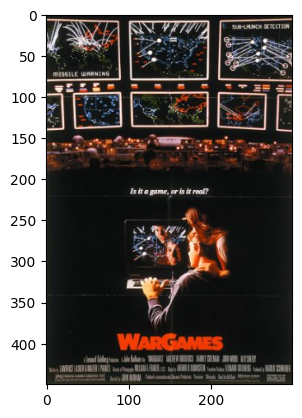

In [10]:
pred_single = trainer.base_model.predict(data[data['fold'] == 'test'].iloc[0]['path'])
print(pred_single)
plt.imshow(Image.open(data[data['fold'] == 'test'].iloc[0]['path']))


In [19]:
# Obtain the index_to_class dict
idx_to_class = {v: k for k, v in trainer.base_model.class_to_idx.items()}

# Get the real label name
labels=[]
for i, pred in enumerate(pred_single[0]['prediction']):
    if pred == 1:
        labels.append(idx_to_class[i])

print(f'The labels are: {labels}')


The labels are: ['Drama']


## Load model with custom weights

In [11]:

vc = VisionClassifier(model_name=model_name, num_classes = 25, weights_path = 'test_trainer.pt', device = 'cuda:0', task = 'multi_label')


Now we can use this model to predict a folder with images, a dataset or a single image.